In [3]:
import pandas as pd
import numpy as np
import networkx as nx
# import geopandas as gpd
import torch
import math
import os
import sys

script_dir = os.getcwd()
src_dir = "/".join(script_dir.split("/")[:-2]) # src directory is two levels up
sys.path.append(src_dir)

from src.bax.alg.dijkstra import DijkstraNx
from src.experiment_manager import experiment_manager
from src.performance_metrics import NewShortestPathCost


/opt/conda/envs/PSBAX/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
def haversine(lat1, lon1, lat2, lon2):
    R = 6371.0 # Radius of the Earth in kilometers
    lat1, lon1, lat2, lon2 = map(math.radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = math.sin(dlat / 2)**2 + math.cos(lat1) * math.cos(lat2) * math.sin(dlon / 2)**2
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))
    distance = R * c
    return distance

def euclidean(lon1, lat1, lon2, lat2):
    return math.sqrt((lon1 - lon2)**2 + (lat1 - lat2)**2)

def calculate_work(u, v, mu=10):
    '''
    Args: 
        u, v: (longitude, latitude, elevation)
        mu: coefficient of friction
    '''
    g = 9.81  # gravity in m/s^2
    long_u, lat_u, elev_u = u
    long_v, lat_v, elev_v = v
    # d = haversine(lat_u, long_u, lat_v, long_v) * 1000
    d = euclidean(long_u, lat_u, long_v, lat_v) * 1000
    
    delta_elev = elev_v - elev_u
    W_gravity = g * delta_elev # work due to gravity (unit mass)
    W_friction = mu * g * d # work due to friction
    # print("W_gravity:", W_gravity)
    # print("W_friction:", W_friction)
    total_work = W_gravity + W_friction
    return total_work / 10000

def calculate_energy(u, v):
    m = 1830 # mass of the vehicle in kg
    C_r = 0.01 # rolling resistance coefficient
    A = 2.6 # frontal area in m^2
    C_d = 0.35 # drag coefficient
    g = 9.81  # gravity in m/s^2
    rho = 1.225 # air density in kg/m^3
    velocity = 40 # velocity in m/s
    long_u, lat_u, elev_u = u
    long_v, lat_v, elev_v = v

    d = euclidean(long_u, lat_u, long_v, lat_v) * 1000
    delta_elev = elev_v - elev_u
    h = np.sqrt(d**2 + delta_elev**2)
    sin = delta_elev / h
    cos = d / h

    energy = m * g * d * sin + m * g * C_r * d * cos + 0.5 * C_d * A * rho * d * velocity**2 
    # print(f'first term: {m * g * d * sin}, second term: {m * g * C_r * d * cos}, third term: {0.5 * C_d * A * rho * d * velocity**2}\n')
    # print(f'second term: {m * g * C_r * d * cos}')
    # print(f'third term: {0.5 * C_d * A * rho * d * velocity**2}')

    return np.max([energy / 3600, 0])

In [5]:
df_edges = pd.read_csv(f"{script_dir}/data/california_edges.csv", index_col="edgeid")
df_nodes = pd.read_csv(f"{script_dir}/data/california_nodes.csv", index_col="nodeid")
df_nodes["norm_longitude"] = (df_nodes["longitude"] - df_nodes["longitude"].min()) / (df_nodes["longitude"].max() - df_nodes["longitude"].min())
df_nodes["norm_latitude"] = (df_nodes["latitude"] - df_nodes["latitude"].min()) / (df_nodes["latitude"].max() - df_nodes["latitude"].min())
df_edges_clone = df_edges.copy()
df_edges_clone["start_nodeid"] = df_edges["end_nodeid"]
df_edges_clone["end_nodeid"] = df_edges["start_nodeid"]
df_edges = pd.concat([df_edges, df_edges_clone], ignore_index=True)


def from_row_to_coord(row):
    u, v = row["start_nodeid"], row["end_nodeid"]
    start_node = df_nodes.loc[u]
    end_node = df_nodes.loc[v]
    edge = np.array([start_node["norm_longitude"], start_node["norm_latitude"], end_node["norm_longitude"], end_node["norm_latitude"]])
    return edge

def from_row_to_work(row):
    u, v = row["start_nodeid"], row["end_nodeid"]
    start_node = df_nodes.loc[u]
    end_node = df_nodes.loc[v]
    tuple1 = (start_node["longitude"], start_node["latitude"], start_node["elevation"])
    tuple2 = (end_node["longitude"], end_node["latitude"], end_node["elevation"])
    # tuple1 = (start_node["norm_longitude"], start_node["norm_latitude"], start_node["elevation"])
    # tuple2 = (end_node["norm_longitude"], end_node["norm_latitude"], end_node["elevation"])
    return calculate_work(tuple1, tuple2)

def from_row_to_energy(row):
    u, v = row["start_nodeid"], row["end_nodeid"]
    start_node = df_nodes.loc[u]
    end_node = df_nodes.loc[v]
    tuple1 = (start_node["longitude"], start_node["latitude"], start_node["elevation"])
    tuple2 = (end_node["longitude"], end_node["latitude"], end_node["elevation"])
    return calculate_energy(tuple1, tuple2)



df_edges["coord"] = df_edges.apply(from_row_to_coord, axis=1)
# df_edges["work"] = df_edges.apply(from_row_to_work, axis=1)
df_edges["fx"] = df_edges.apply(from_row_to_energy, axis=1)
edge_coords = np.vstack(df_edges["coord"])
# normalize edge coords to 0, 1
# edge_coords = (edge_coords - edge_coords.min(axis=0)) / (edge_coords.max(axis=0) - edge_coords.min(axis=0))
# assign new coords to df_edges["coord"]
df_edges["coord"] = list(edge_coords)
edge_fx = df_edges["fx"].to_numpy()
edge_coord_to_fx = {tuple(e): w for e, w in zip(edge_coords, edge_fx)}


first term: 316557.80531682697, second term: 591.5171532200112, third term: 15997.533115479391

first term: 230784.43877071046, second term: 705.0432939452157, third term: 11987.521761491571

first term: 119231.46907794318, second term: 3581.1930427917496, third term: 18750.046327381402

first term: -67560.6945805914, second term: 1875.7961390119237, third term: 9904.190637207566

first term: 548110.6755604243, second term: 1797.0539349312016, third term: 28654.07508405795

first term: 103800.84376068457, second term: 3745.23481560116, third term: 19306.203808440525

first term: 39806.26564437223, second term: 436.78779217761985, third term: 2935.6736691456435

first term: -42139.689146796525, second term: 16.49847911126014, third term: 2094.9386152565344

first term: 116890.3994754191, second term: 144.6985008690545, third term: 5850.978826036464

first term: 133691.63800345815, second term: 330.8523454606723, third term: 6841.62293822749

first term: 496087.70620601927, second term: 

In [6]:
start = 3939
goal = 446

G = nx.from_pandas_edgelist(df_edges, source="start_nodeid", target="end_nodeid", edge_attr=True, create_using=nx.DiGraph)


In [7]:
def softplus_np(x): return np.log1p(np.exp(-np.abs(x))) + np.maximum(x, 0)

def weight_func(u, v, d):
    coord = tuple(G[u][v]["coord"])
    # fx = edge_coord_to_fx[coord]
    fx = G[u][v]["fx"]
    return softplus_np(fx)

P = nx.dijkstra_path(G, start, goal, weight=weight_func)
def cost_of_path(P):
    cost = 0
    for i in range(len(P) - 1):
        u, v = P[i], P[i+1]
        cost += G[u][v]["fx"]
    return cost

P_cost = cost_of_path(P)

In [8]:
u, v = 445, 446
coord = tuple(G[u][v]["coord"])
fx = edge_coord_to_fx[coord]
print(f'fx of edge {u} -> {v} with coord {coord}: {fx}')

coord = (
    df_nodes.loc[u]["norm_longitude"], 
    df_nodes.loc[u]["norm_latitude"],
    df_nodes.loc[v]["norm_longitude"], 
    df_nodes.loc[v]["norm_latitude"]
)
fx = edge_coord_to_fx[coord]
print(f'fx of edge {u} -> {v} with coord {coord}: {fx}')

fx of edge 445 -> 446 with coord (0.06469164187494515, 0.8955720459430795, 0.06459228605407744, 0.896408232260125): 6.390558861205358
fx of edge 445 -> 446 with coord (0.06469164187494515, 0.8955720459430795, 0.06459228605407744, 0.896408232260125): 6.390558861205358


In [9]:
G[445][446]["fx"]

6.390558861205358

In [10]:
edge_pos = []
edges_weights = []
true_cost = 0
for i in range(len(P)-1):
    u, v = P[i], P[i+1]
    coord = (
        df_nodes.loc[u]["norm_longitude"], 
        df_nodes.loc[u]["norm_latitude"],
        df_nodes.loc[v]["norm_longitude"], 
        df_nodes.loc[v]["norm_latitude"]
    )
    edge_pos.append(coord)
    edges_weights.append(edge_coord_to_fx[coord])
    edge = df_edges[
        (df_edges["start_nodeid"] == u) & (df_edges["end_nodeid"] == v)
    ]
    true_cost += edge["fx"].values[0]

print(f"true cost: {true_cost}")

true cost: 5050.53365823729


In [11]:
edge= df_edges[
        (df_edges["start_nodeid"] == 445) & (df_edges["end_nodeid"] == 446)
    ]
print(edge["fx"].values[0])

6.390558861205358


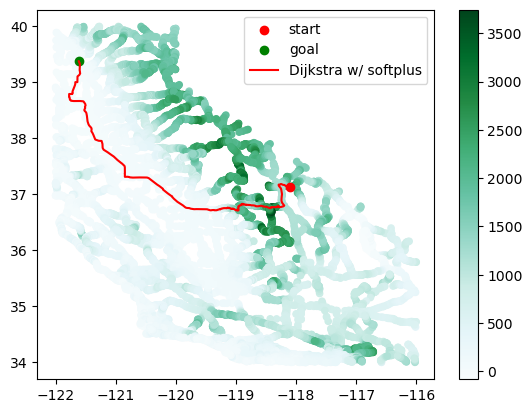

In [12]:
import matplotlib.pyplot as plt
# Plot the graph
fig, ax = plt.subplots()

start_coords = df_nodes.loc[start][["longitude", "latitude"]]
goal_coords = df_nodes.loc[goal][["longitude", "latitude"]]

points = ax.scatter(df_nodes["longitude"], df_nodes["latitude"], c=df_nodes["elevation"], s=20, cmap="BuGn")

# plot start and end
ax.scatter(start_coords["longitude"], start_coords["latitude"], color="red", label="start")
ax.scatter(goal_coords["longitude"], goal_coords["latitude"], color="green", label="goal")

P_nodes = [
    (df_nodes.loc[u]["longitude"], df_nodes.loc[u]["latitude"])
    for u in P
]
P_nodes = np.array(P_nodes)
ax.plot(P_nodes[:, 0], P_nodes[:, 1], color="red", label="Dijkstra w/ softplus")
fig.colorbar(points)
ax.legend()
plt.show()


MSE: 0.05195715086382079


Text(0.5, 1.0, 'Euclidean distance vs Work')

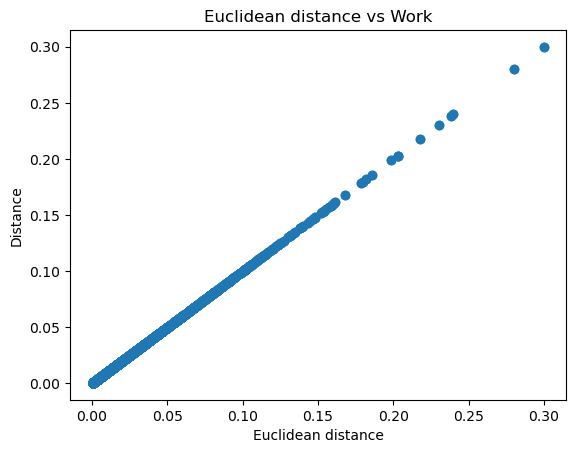

In [16]:
# plot difference between euc_dist vs distance
import matplotlib.pyplot as plt
mse = np.mean((df_edges["euc_dist"] - df_edges["work"])**2)
print("MSE:", mse)
plt.scatter(df_edges["euc_dist"], df_edges["distance"])
# plt.scatter(df_edges["euc_dist"], df_edges["work"])
plt.xlabel("Euclidean distance")
plt.ylabel("Distance")
plt.title("Euclidean distance vs Work")



# Initial processing

In [7]:
# Load node and edge data from https://www.cs.utah.edu/~lifeifei/SpatialDataset.htm
df_edges = pd.read_csv("data/cal.cedge", delim_whitespace=True, names=["edgeid", "start_nodeid", "end_nodeid", "distance"], index_col="edgeid")
# df_nodes = pd.read_csv("data/cal.cnode", delim_whitespace=True, names=["nodeid", "longitude", "latitude"], index_col="nodeid")
df_nodes = pd.read_csv("data/nodes_with_elevation.csv", index_col="nodeid")

NameError: name 'df_nodes_with_elevation' is not defined

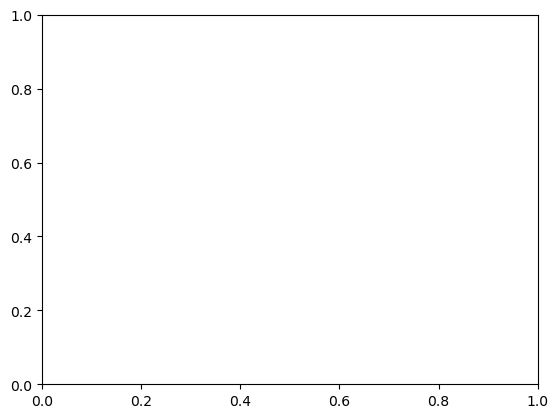

In [8]:
import matplotlib.pyplot as plt
import matplotlib

fig, ax = plt.subplots()
points = ax.scatter(df_nodes_with_elevation["longitude"], df_nodes_with_elevation["latitude"], c=df_nodes_with_elevation["elevation"], s=20, cmap="BuGn")
start = (-121, 39)
end = (-117, 35)
# ax.plot([start[0], end[0]], [start[1], end[1]], color="red")
ax.scatter([start[0], end[0]], [start[1], end[1]], color="red")

fig.colorbar(points)

In [ ]:
start = (-121, 39)
end = (-117, 35)

# find the closest node to the start and end points
start_node = df_nodes.iloc[((df_nodes["longitude"] - start[0])**2 + (df_nodes["latitude"] - start[1])**2).idxmin()]
end_node = df_nodes.iloc[((df_nodes["longitude"] - end[0])**2 + (df_nodes["latitude"] - end[1])**2).idxmin()]

In [ ]:
lat_low, lat_high = 34, 40
lon_low, lon_high = -122, -116
df_ba_nodes = df_nodes[(lat_low <= df_nodes["latitude"])
                     & (df_nodes["latitude"] <= lat_high)
                     & (lon_low <= df_nodes["longitude"])
                     & (df_nodes["longitude"]<= lon_high)]
print(df_ba_nodes.shape) # (11213, 2)
df_ba_edges = df_edges.reset_index().merge(df_ba_nodes, how="inner", left_on="start_nodeid", right_on="nodeid")
# inner uses the intersection of keys from both frames; preserve the order of the left keys
# df_ba_edges.shape (11598, 6)
df_ba_edges = df_ba_edges.merge(df_ba_nodes, how="inner", left_on="end_nodeid", right_on="nodeid")
# df_ba_edges.shape (11565, 8)


(11213, 3)


In [ ]:
# Use the mean of two endpoints as the longitude/latitude of an edge
df_ba_edges["mean_longitude"] = (df_ba_edges["longitude_x"] + df_ba_edges["longitude_y"]) / 2
df_ba_edges["mean_latitude"] = (df_ba_edges["latitude_x"] + df_ba_edges["latitude_y"]) / 2
df_ba_edges["mean_elevation"] = (df_ba_edges["elevation_x"] + df_ba_edges["elevation_y"]) / 2
assert df_ba_nodes.reset_index()["nodeid"].is_unique
old_to_new_nodeid = dict(zip(df_ba_nodes.reset_index()["nodeid"], df_ba_nodes.reset_index().index))
df_ba_nodes_new = df_ba_nodes.reset_index().replace({"nodeid": old_to_new_nodeid})
df_ba_edges_new = df_ba_edges.replace({"start_nodeid": old_to_new_nodeid, "end_nodeid": old_to_new_nodeid})

In [ ]:
df_ba_nodes_new.to_csv("data/ba_nodes_new.csv", index=False)
df_ba_edges_new.to_csv("data/ba_edges_new.csv", index=False)

In [4]:
# New df_edges and df_nodes
df_edges = pd.read_csv("./data/ba_edges_new.csv", index_col="edgeid")
df_nodes = pd.read_csv("./data/ba_nodes_new.csv", index_col="nodeid")

edge_elevation = df_edges["mean_elevation"].to_numpy()

df_nodes["norm_longitude"] = (df_nodes["longitude"] - df_nodes["longitude"].min()) / (df_nodes["longitude"].max() - df_nodes["longitude"].min())
df_nodes["norm_latitude"] = (df_nodes["latitude"] - df_nodes["latitude"].min()) / (df_nodes["latitude"].max() - df_nodes["latitude"].min())

# set df_edges["norm_longitude"] based on start_nodeif and end_nodeid from df_nodes
df_edges["norm_longitude_x"] = df_nodes.loc[df_edges["start_nodeid"]]["norm_longitude"].to_numpy()
df_edges["norm_longitude_y"] = df_nodes.loc[df_edges["end_nodeid"]]["norm_longitude"].to_numpy()
df_edges["norm_longitude"] = (df_edges["norm_longitude_x"] + df_edges["norm_longitude_y"]) / 2
df_edges["norm_latitude_x"] = df_nodes.loc[df_edges["start_nodeid"]]["norm_latitude"].to_numpy()
df_edges["norm_latitude_y"] = df_nodes.loc[df_edges["end_nodeid"]]["norm_latitude"].to_numpy()
df_edges["norm_latitude"] = (df_edges["norm_latitude_x"] + df_edges["norm_latitude_y"]) / 2

df_edges.to_csv("data/new_edges.csv")
df_nodes.to_csv("data/new_nodes.csv")

# df_edges["standardized_weight"] = (df_edges["mean_elevation"] - df_edges["mean_elevation"].mean()) / df_edges["mean_elevation"].std()
df_edges["pos_weight"] = df_edges["mean_elevation"] - df_edges["mean_elevation"].min() 

# find the closest node to the start and end points
start = (-121, 39)
end = (-117, 35)
start_node = df_nodes.iloc[((df_nodes["longitude"] - start[0])**2 + (df_nodes["latitude"] - start[1])**2).idxmin()]
end_node = df_nodes.iloc[((df_nodes["longitude"] - end[0])**2 + (df_nodes["latitude"] - end[1])**2).idxmin()]



# Get edge representations

In [10]:
df_edges = pd.read_csv(f"data/california_edges.csv", index_col="edgeid")
df_nodes = pd.read_csv(f"data/california_nodes.csv", index_col="nodeid")

In [13]:
# clone df_edges
# drop edge id
# df_edges = df_edges.drop(columns=["edge_id"])
df_edges_clone = df_edges.copy()


# switch df_edges["start_nodeid"] and df_edges["end_nodeid"]
df_edges_clone["start_nodeid"] = df_edges["end_nodeid"]
df_edges_clone["end_nodeid"] = df_edges["start_nodeid"]
# add the two dataframes together
df_edges_undirected = pd.concat([df_edges, df_edges_clone], ignore_index=True)


In [12]:
df_edges.head()

,start_nodeid,end_nodeid,distance
edgeid,,,
3482,1,14,0.017938
3527,13,14,0.013442
3505,2,22,0.021025
3510,3,4,0.011105
3511,3,124,0.032130


In [14]:
df_edges_undirected


,start_nodeid,end_nodeid,distance
0,1,14,0.017938
1,13,14,0.013442
2,2,22,0.021025
3,3,4,0.011105
4,3,124,0.032130
...,...,...,...
23125,11207,11206,0.023633
23126,11208,11207,0.016076
23127,11209,11208,0.007133
23128,11210,11209,0.008105


In [7]:
df_edges = pd.read_csv(f"data/california_edges.csv", index_col="edgeid")
df_nodes = pd.read_csv(f"data/california_nodes.csv", index_col="nodeid")

def from_row_to_coord(row):
    u, v = row["start_nodeid"], row["end_nodeid"]
    start_node = df_nodes.loc[u]
    end_node = df_nodes.loc[v]
    edge = (start_node["longitude"], start_node["latitude"], end_node["longitude"], end_node["latitude"])
    return edge

# df_edges["edge_coord"] = df_edges.apply(from_row_to_coord, axis=1)

def from_row_to_work(row):
    u, v = row["start_nodeid"], row["end_nodeid"]
    start_node = df_nodes.loc[u]
    end_node = df_nodes.loc[v]
    tuple1 = (start_node["longitude"], start_node["latitude"], start_node["elevation"])
    tuple2 = (end_node["longitude"], end_node["latitude"], end_node["elevation"])
    return calculate_work(tuple1, tuple2)


In [10]:
df_edges["coord"] = df_edges.apply(from_row_to_coord, axis=1)
df_edges["work"] = df_edges.apply(from_row_to_work, axis=1)
edge_coords = df_edges["coord"].to_numpy()
edge_work = df_edges["work"].to_numpy()
edge_coord_to_work = dict(zip(edge_coords, edge_work))



In [8]:
edge_coords = df_edges.apply(from_row_to_coord, axis=1).to_numpy()

edge_work = df_edges.apply(from_row_to_work, axis=1).to_numpy()

edge_coord_to_work = dict(zip(edge_coords, edge_work))

In [9]:
edge_coord_to_work

{(-120.953934, 40.0, -120.941147, 39.987419): 2681.0975132968642,
 (-120.935493, 39.975224, -120.941147, 39.987419): 1843.3498875900186,
 (-120.57737, 40.0, -120.568733, 39.980831): 2280.7504863771,
 (-120.034241, 39.953167, -120.024017, 39.957504): 937.8264108195104,
 (-120.034241, 39.953167, -120.014008, 39.928207): 4167.079109189455,
 (-120.024017, 39.957504, -120.003197, 39.963436): 1915.9993560289606,
 (-120.003197, 39.963436, -119.999908, 39.963299): 304.81803329636887,
 (-120.949043, 39.932281, -120.94857, 39.934582): -334.5028829341811,
 (-120.949043, 39.932281, -120.942673, 39.93071): 1079.6324820171021,
 (-120.949043, 39.932281, -120.956543, 39.933895): 955.6745661962718,
 (-120.983757, 39.944321, -120.956543, 39.933895): 3397.86850567889,
 (-120.94857, 39.934582, -120.950081, 39.940945): 538.7314632200715,
 (-120.950081, 39.940945, -120.949707, 39.945534): 491.74455811749783,
 (-120.949707, 39.945534, -120.938858, 39.959572): 2260.539818909446,
 (-120.938858, 39.959572, -120

# Calculate Work

In [15]:
df_edges = pd.read_csv("./data/california_edges.csv", index_col="edgeid")
df_nodes = pd.read_csv("./data/california_nodes.csv", index_col="nodeid")

# drop_columns = [
#     # "longitude_x", 
#     # "latitude_x", 
#     # "elevation_x", 
#     # "elevation_x", 
#     # "longitude_y",
#     # "latitude_y",
#     # "elevation_y",
#     # "mean_longitude",
#     # "mean_latitude",
#     # "mean_elevation",
#     # "norm_longitude_x",
#     # "norm_latitude_x",
#     "norm_longitude",
#     # "norm_longitude_y",
#     # "norm_latitude_y",
#     "norm_latitude",
# ]
# df_edges = df_edges.drop(columns=drop_columns)

G = nx.from_pandas_edgelist(df_edges, source="start_nodeid", target="end_nodeid", edge_attr=True)
G = nx.DiGraph(G)

In [16]:
def haversine(lat1, lon1, lat2, lon2):
    # Radius of the Earth in kilometers
    R = 6371.0
    lat1, lon1, lat2, lon2 = map(math.radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    
    # Haversine formula
    a = math.sin(dlat / 2)**2 + math.cos(lat1) * math.cos(lat2) * math.sin(dlon / 2)**2
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))
    distance = R * c
    return distance

def calculate_work(u, v, mu=0.1):
    # Constants
    g = 9.81  # gravity in m/s^2
    
    # Unpack points
    long_u, lat_u, elev_u = u
    long_v, lat_v, elev_v = v
    
    # Calculate the horizontal distance in kilometers and convert to meters
    d = haversine(lat_u, long_u, lat_v, long_v) * 1000
    
    delta_elev = elev_v - elev_u
    W_gravity = g * delta_elev # work due to gravity (unit mass)
    
    # Calculate work due to friction
    W_friction = mu * g * d # work due to friction
    # print("W_gravity:", W_gravity)
    # print("W_friction:", W_friction)
    
    # Total work
    total_work = W_gravity + W_friction
    return total_work

def softplus_np(x): return np.log1p(np.exp(-np.abs(x))) + np.maximum(x, 0)

def scaled_work(u, v, d):
    
    lon_u, lat_u, elev_u = df_nodes.loc[u]["longitude"], df_nodes.loc[u]["latitude"], df_nodes.loc[u]["elevation"]
    lon_v, lat_v, elev_v = df_nodes.loc[v]["longitude"], df_nodes.loc[v]["latitude"], df_nodes.loc[v]["elevation"]
    
    work = calculate_work((lon_u, lat_u, elev_u), (lon_v, lat_v, elev_v))
    return softplus_np(work)

# Example usage:
u = (-123.1, 49.2, 50)  # Longitude, latitude, elevation
v = (-122.9, 49.1, 400) # Longitude, latitude, elevation
mu = 0.1  # Coefficient of friction

work = calculate_work(u, v, mu)
print("Total work required:", work, "Joules")

Total work required: 21394.95521652807 Joules


In [17]:
# calculate the work using apply for df_edges

# df_edges["work"] = df_edges.apply(lambda row: calculate_work(
#     (row["longitude_x"], row["latitude_x"], row["elevation_x"]),
#     (row["longitude_y"], row["latitude_y"], row["elevation_y"]),
# ), axis=1)

min_work = np.inf
for u, v, data in G.edges(data=True):
    data["work"] = calculate_work(
        (df_nodes.loc[u]["longitude"], df_nodes.loc[u]["latitude"], df_nodes.loc[u]["elevation"]),
        (df_nodes.loc[v]["longitude"], df_nodes.loc[v]["latitude"], df_nodes.loc[v]["elevation"]),
    )
    data["sp_work"] = softplus_np(data["work"])
    min_work = min(min_work, data["work"])

for u, v, data in G.edges(data=True):
    data["pos_work"] = data["work"] - min_work

In [40]:
df_edges.iloc[0]

start_nodeid     1.000000
end_nodeid      14.000000
distance         0.017938
Name: 3482, dtype: float64

In [26]:
u = 1
# get df_nodes.loc[u]["longitude"], df_nodes.loc[u]["latitude"], df_nodes.loc[u]["elevation"]
print(df_nodes.loc[u]["longitude"], df_nodes.loc[u]["latitude"], df_nodes.loc[u]["elevation"])
v = 14
print(df_nodes.loc[v]["longitude"], df_nodes.loc[v]["latitude"], df_nodes.loc[v]["elevation"])

print(calculate_work(
    (df_nodes.loc[u]["longitude"], df_nodes.loc[u]["latitude"], df_nodes.loc[u]["elevation"]),
    (df_nodes.loc[v]["longitude"], df_nodes.loc[v]["latitude"], df_nodes.loc[v]["elevation"]),
))

print(calculate_work(
    (df_nodes.loc[v]["longitude"], df_nodes.loc[v]["latitude"], df_nodes.loc[v]["elevation"]),
    (df_nodes.loc[u]["longitude"], df_nodes.loc[u]["latitude"], df_nodes.loc[u]["elevation"]),
))

-120.953934 40.0 1003.0
-120.941147 39.987419 1099.0
W_gravity: 941.76
W_friction: 1739.337513296864
2681.0975132968642
W_gravity: -941.76
W_friction: 1739.337513296864
797.577513296864


In [45]:
G[1][14]

{'distance': 0.017938,
 'work': 2681.0975132968642,
 'sp_work': 2681.0975132968642,
 'pos_work': 7731.301308891116}

In [29]:
# start = (-121, 39)
# end = (-117, 35)
# start_node = df_nodes.iloc[((df_nodes["longitude"] - start[0])**2 + (df_nodes["latitude"] - start[1])**2).idxmin()]
# end_node = df_nodes.iloc[((df_nodes["longitude"] - end[0])**2 + (df_nodes["latitude"] - end[1])**2).idxmin()]

santa_cruz = (-122.045158, 36.961494)
lake_tahoe = (-120.0, 38.913666)
start_node = df_nodes.iloc[((df_nodes["longitude"] - santa_cruz[0])**2 + (df_nodes["latitude"] - santa_cruz[1])**2).idxmin()]
end_node = df_nodes.iloc[((df_nodes["longitude"] - lake_tahoe[0])**2 + (df_nodes["latitude"] - lake_tahoe[1])**2).idxmin()]

P = nx.shortest_path(G, source=start_node.name, target=end_node.name, weight="sp_work")
P_pos = nx.shortest_path(G, source=start_node.name, target=end_node.name, weight="pos_work")
P_bf_path = nx.bellman_ford_path(G, source=start_node.name, target=end_node.name, weight="work")

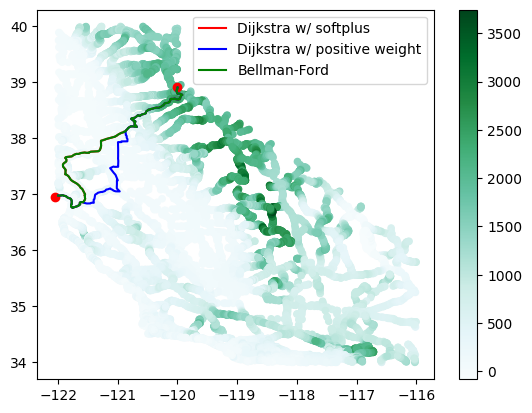

In [30]:
import matplotlib.pyplot as plt
# Plot the graph
fig, ax = plt.subplots()

points = ax.scatter(df_nodes["longitude"], df_nodes["latitude"], c=df_nodes["elevation"], s=20, cmap="BuGn")
# start = (df_nodes.loc[bax_start_node]["longitude"], df_nodes.loc[bax_start_node]["latitude"])
# end = (df_nodes.loc[bax_end_node]["longitude"], df_nodes.loc[bax_end_node]["latitude"])
# ax.scatter([start[0], end[0]], [start[1], end[1]], color="red")
ax.scatter([santa_cruz[0], lake_tahoe[0]], [santa_cruz[1], lake_tahoe[1]], color="red")
P_nodes = [
    (df_nodes.loc[u]["longitude"], df_nodes.loc[u]["latitude"])
    for u in P
]
P_nodes = np.array(P_nodes)
ax.plot(P_nodes[:, 0], P_nodes[:, 1], color="red", label="Dijkstra w/ softplus")
fig.colorbar(points)
P_pos_nodes = [
    (df_nodes.loc[u]["longitude"], df_nodes.loc[u]["latitude"])
    for u in P_pos
]
P_pos_nodes = np.array(P_pos_nodes)
ax.plot(P_pos_nodes[:, 0], P_pos_nodes[:, 1], color="blue", label="Dijkstra w/ positive weight")

P_bf_nodes = [
    (df_nodes.loc[u]["longitude"], df_nodes.loc[u]["latitude"])
    for u in P_bf_path
]
P_bf_nodes = np.array(P_bf_nodes)
ax.plot(P_bf_nodes[:, 0], P_bf_nodes[:, 1], color="green", label="Bellman-Ford")
ax.legend()
plt.show()


# plot the shortest path
# nx.draw(G, pos=df_nodes[["norm_longitude", "norm_latitude"]].to_numpy(), node_size=20, ax=ax, edge_color="gray")
# nx.draw_networkx_edges(G, pos=df_nodes[["norm_longitude", "norm_latitude"]].to_numpy(), edgelist=[(P[i], P[i+1]) for i in range(len(P) - 1)], edge_color="red", ax=ax)


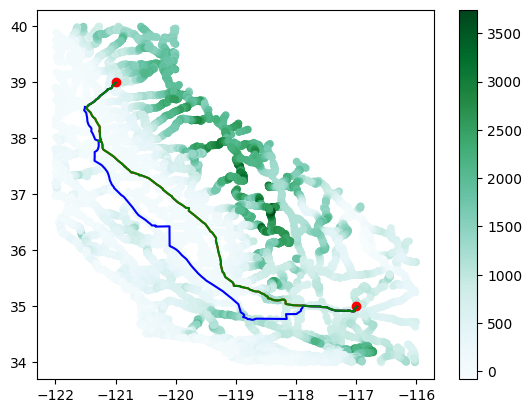

In [61]:
# Plot the graph
fig, ax = plt.subplots()
points = ax.scatter(df_nodes["longitude"], df_nodes["latitude"], c=df_nodes["elevation"], s=20, cmap="BuGn")
start = (-121, 39)
end = (-117, 35)
ax.scatter([start[0], end[0]], [start[1], end[1]], color="red")
P_nodes = [
    (df_nodes.loc[u]["longitude"], df_nodes.loc[u]["latitude"])
    for u in P
]
P_nodes = np.array(P_nodes)
ax.plot(P_nodes[:, 0], P_nodes[:, 1], color="red", label="Dijkstra w/ softplus")
fig.colorbar(points)
P_pos_nodes = [
    (df_nodes.loc[u]["longitude"], df_nodes.loc[u]["latitude"])
    for u in P_pos
]
P_pos_nodes = np.array(P_pos_nodes)
ax.plot(P_pos_nodes[:, 0], P_pos_nodes[:, 1], color="blue", label="Dijkstra w/ positive weight")

P_bf_nodes = [
    (df_nodes.loc[u]["longitude"], df_nodes.loc[u]["latitude"])
    for u in P_bf_path
]
P_bf_nodes = np.array(P_bf_nodes)
ax.plot(P_bf_nodes[:, 0], P_bf_nodes[:, 1], color="green", label="Bellman-Ford")
plt.show()


# plot the shortest path
# nx.draw(G, pos=df_nodes[["norm_longitude", "norm_latitude"]].to_numpy(), node_size=20, ax=ax, edge_color="gray")
# nx.draw_networkx_edges(G, pos=df_nodes[["norm_longitude", "norm_latitude"]].to_numpy(), edgelist=[(P[i], P[i+1]) for i in range(len(P) - 1)], edge_color="red", ax=ax)


In [26]:

start = (-121, 39)
end = (-117, 35)
start_node = df_nodes.iloc[((df_nodes["longitude"] - start[0])**2 + (df_nodes["latitude"] - start[1])**2).idxmin()]
end_node = df_nodes.iloc[((df_nodes["longitude"] - end[0])**2 + (df_nodes["latitude"] - end[1])**2).idxmin()]

P = nx.shortest_path(G, source=start_node.name, target=end_node.name, weight="sp_work")
P_pos = nx.shortest_path(G, source=start_node.name, target=end_node.name, weight="pos_work")
P_bf_path = nx.bellman_ford_path(G, source=start_node.name, target=end_node.name, weight="work")

# bax_start_node = 3939
# bax_end_node = 446

# P = nx.shortest_path(G, source=bax_start_node, target=bax_end_node, weight="sp_work")
# P_pos = nx.shortest_path(G, source=bax_start_node, target=bax_end_node, weight="pos_work")
# P_bf_path = nx.bellman_ford_path(G, source=bax_start_node, target=bax_end_node, weight="work")

In [27]:
import matplotlib.pyplot as plt

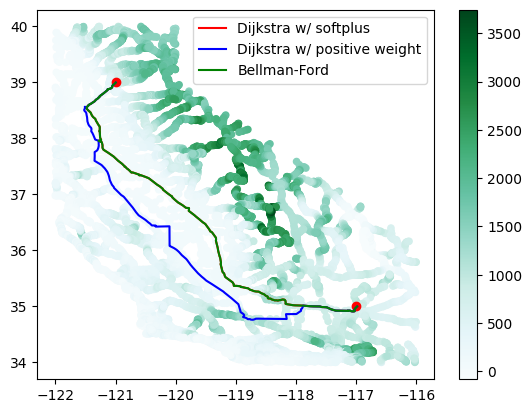

In [28]:
# Plot the graph
fig, ax = plt.subplots()

points = ax.scatter(df_nodes["longitude"], df_nodes["latitude"], c=df_nodes["elevation"], s=20, cmap="BuGn")
# start = (df_nodes.loc[bax_start_node]["longitude"], df_nodes.loc[bax_start_node]["latitude"])
# end = (df_nodes.loc[bax_end_node]["longitude"], df_nodes.loc[bax_end_node]["latitude"])
ax.scatter([start[0], end[0]], [start[1], end[1]], color="red")
P_nodes = [
    (df_nodes.loc[u]["longitude"], df_nodes.loc[u]["latitude"])
    for u in P
]
P_nodes = np.array(P_nodes)
ax.plot(P_nodes[:, 0], P_nodes[:, 1], color="red", label="Dijkstra w/ softplus")
fig.colorbar(points)
P_pos_nodes = [
    (df_nodes.loc[u]["longitude"], df_nodes.loc[u]["latitude"])
    for u in P_pos
]
P_pos_nodes = np.array(P_pos_nodes)
ax.plot(P_pos_nodes[:, 0], P_pos_nodes[:, 1], color="blue", label="Dijkstra w/ positive weight")

P_bf_nodes = [
    (df_nodes.loc[u]["longitude"], df_nodes.loc[u]["latitude"])
    for u in P_bf_path
]
P_bf_nodes = np.array(P_bf_nodes)
ax.plot(P_bf_nodes[:, 0], P_bf_nodes[:, 1], color="green", label="Bellman-Ford")
ax.legend()
plt.show()


# plot the shortest path
# nx.draw(G, pos=df_nodes[["norm_longitude", "norm_latitude"]].to_numpy(), node_size=20, ax=ax, edge_color="gray")
# nx.draw_networkx_edges(G, pos=df_nodes[["norm_longitude", "norm_latitude"]].to_numpy(), edgelist=[(P[i], P[i+1]) for i in range(len(P) - 1)], edge_color="red", ax=ax)


In [ ]:
def softplus_np(x):
        return np.log1p(np.exp(-np.abs(x))) + np.maximum(x, 0)

In [62]:
# COPY g
g = G.copy()

In [63]:
# Delete the work attribute from the edges
for u, v, data in g.edges(data=True):
    del data["work"]
    del data["sp_work"]
    del data["pos_work"]

In [64]:
G.get_edge_data(1, 14)

{'distance': 0.017938,
 'work': 2681.0975132968642,
 'sp_work': 2681.0975132968642,
 'pos_work': 7731.301308891116}

In [65]:
g.get_edge_data(1, 14)

{'distance': 0.017938}

In [48]:
def cost_of_path(P):
    cost = 0
    for i in range(len(P) - 1):
        u, v = P[i], P[i+1]
        cost += G[u][v]["work"]
    return cost

P_cost = cost_of_path(P)
P_pos_cost = cost_of_path(P_pos)

In [49]:
print("Cost of path:", P_cost)
print("Cost of path (pos):", P_pos_cost)

Cost of path: 720035.4549000695
Cost of path (pos): 788921.0881183967


# Test algo

In [25]:
df_edges = pd.read_csv("./data/new_edges.csv", index_col="edgeid")
df_nodes = pd.read_csv("./data/new_nodes.csv", index_col="nodeid")


df_edges["pos_weight"] = df_edges["mean_elevation"] - df_edges["mean_elevation"].min() 

# find the closest node to the start and end points
start = (-121, 39)
end = (-117, 35)
start_node = df_nodes.iloc[((df_nodes["longitude"] - start[0])**2 + (df_nodes["latitude"] - start[1])**2).idxmin()]
end_node = df_nodes.iloc[((df_nodes["longitude"] - end[0])**2 + (df_nodes["latitude"] - end[1])**2).idxmin()]

edge_positions = df_edges[["norm_longitude", "norm_latitude"]].to_numpy()
edge_pos_to_weight = {tuple(e): w for e, w in zip(edge_positions, df_edges["pos_weight"])}

In [17]:
G = nx.from_pandas_edgelist(df_edges, source="start_nodeid", target="end_nodeid", edge_attr=True)
# P = nx.dijkstra_path(G, start_node.name, end_node.name, weight="pos_weight")

In [38]:
def softplus(x):
    return np.log1p(np.exp(x))

def softplus_np(x): return np.log1p(np.exp(-np.abs(x))) + np.maximum(x, 0)

def weight_func(u, v, d):
    lon, lat = G[u][v]["norm_longitude"], G[u][v]["norm_latitude"]
    # x = torch.tensor([lon, lat]).reshape(1, -1)
    fx = edge_pos_to_weight[(lon, lat)]
    return softplus_np(fx)

P = nx.dijkstra_path(G, start_node.name, end_node.name, weight=weight_func)
P_weight = nx.dijkstra_path(G, start_node.name, end_node.name, weight="pos_weight")

In [35]:
weight_func(1060, 1059, None)

703.0

In [37]:
end_node

longitude        -116.982483
latitude           35.000000
elevation         839.000000
norm_longitude      0.836442
norm_latitude       0.166647
Name: 8622, dtype: float64

In [39]:
len(P)

284

In [28]:
len(P_weight)

284

In [29]:
def cost_of_path(P):
    cost = 0
    for i in range(len(P) - 1):
        u, v = P[i], P[i+1]
        cost += G[u][v]["pos_weight"]
    return cost

P_cost = cost_of_path(P)
P_weight_cost = cost_of_path(P_weight)

In [30]:
print(P_cost)

113193.0


In [31]:
P_weight_cost

113193.0

In [132]:
bax_start = 3939
bax_end = 446

P_bax = nx.dijkstra_path(G, bax_start, bax_end, weight="pos_weight")
bax_weight = 0
for i in range(len(P_bax) - 1):
    bax_weight += G[P_bax[i]][P_bax[i+1]]["pos_weight"]
bax_weight


192886.5

In [156]:
P_bax


[3939,
 3940,
 3941,
 3942,
 3943,
 3944,
 3945,
 3946,
 3947,
 3852,
 3863,
 3862,
 3861,
 3860,
 3859,
 3864,
 3986,
 3987,
 3988,
 3989,
 3990,
 4228,
 4229,
 4230,
 4231,
 4232,
 4334,
 4335,
 4336,
 4337,
 4338,
 4434,
 4435,
 4436,
 4437,
 4918,
 4919,
 4920,
 4921,
 4922,
 4923,
 4924,
 4925,
 4926,
 4927,
 4928,
 4929,
 4930,
 5661,
 5660,
 5659,
 5658,
 5657,
 5656,
 5655,
 5654,
 5653,
 5652,
 5651,
 5650,
 5641,
 6020,
 6019,
 6018,
 6017,
 6016,
 6015,
 6014,
 6013,
 6012,
 6632,
 6631,
 6630,
 6629,
 6628,
 6685,
 6684,
 6683,
 6916,
 6915,
 7079,
 7080,
 7081,
 7077,
 7264,
 7768,
 7767,
 7766,
 7765,
 7966,
 7965,
 7964,
 7963,
 8022,
 8021,
 8043,
 8362,
 8375,
 8365,
 8397,
 8398,
 8399,
 8400,
 8401,
 8402,
 8403,
 8404,
 8405,
 8406,
 8407,
 8408,
 8409,
 8410,
 8411,
 8412,
 8413,
 8414,
 8415,
 8416,
 8342,
 8343,
 8344,
 8345,
 8346,
 8347,
 8348,
 8349,
 8350,
 8351,
 8352,
 8353,
 8354,
 8355,
 8356,
 8357,
 8358,
 8359,
 8360,
 8361,
 8203,
 8204,
 8205,
 8206,

In [155]:
G[1][14]

{'distance': 0.017938,
 'longitude_x': -120.953934,
 'latitude_x': 40.0,
 'elevation_x': 1003,
 'longitude_y': -120.941147,
 'latitude_y': 39.987419,
 'elevation_y': 1099,
 'mean_longitude': -120.9475405,
 'mean_latitude': 39.9937095,
 'mean_elevation': 1051.0,
 'norm_longitude_x': 0.174383802200564,
 'norm_longitude_y': 0.1765154513304842,
 'norm_longitude': 0.1754496267655241,
 'norm_latitude_x': 1.0,
 'norm_latitude_y': 0.9979031173899258,
 'norm_latitude': 0.9989515586949629,
 'pos_weight': 1133.0}

In [131]:
weight = 0
for i in range(len(P) - 1):
    # df_edges.loc[edge, "highlight"] = True
    edge = (P[i], P[i+1])
    weight += G.edges[edge]["pos_weight"]

weight

113193.0

In [137]:
import os
import sys
import torch 



torch.set_default_dtype(torch.float64)

cwd = os.getcwd()
sys.path.append("/".join(cwd.split("/")[:-2]))
from src.fit_model import fit_model

/opt/conda/envs/PSBAX/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [141]:
# fit a GP on the elevation data
inputs = df_edges[["norm_longitude", "norm_latitude"]].to_numpy()
# choose 10% of inputs

obj_vals = df_edges["pos_weight"].to_numpy()
inputs = torch.from_numpy(inputs)
obj_vals = torch.from_numpy(obj_vals)
n = len(inputs)
idx = np.random.choice(n, int(n * 0.1), replace=False)
inputs = inputs[idx]
obj_vals = obj_vals[idx]
kwargs = {}
model = fit_model(
    inputs,
    obj_vals,
    model_type="gp",
    **kwargs
)


In [148]:
mean

array([[121.95191644],
       [383.97224425],
       [244.78180078],
       ...,
       [393.77357901],
       [ 89.55965241],
       [175.39557167]])

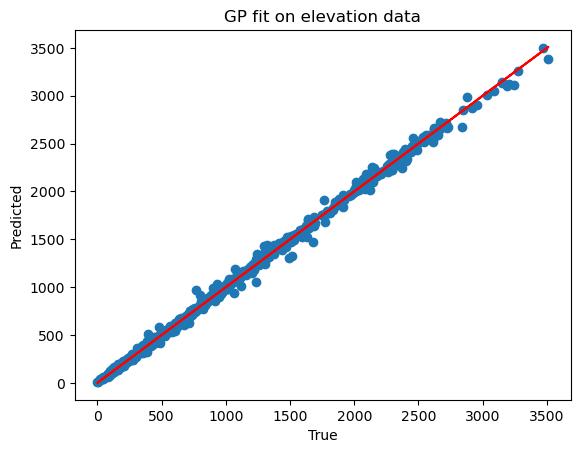

In [153]:
# check model fit
import matplotlib.pyplot as plt

post = model.posterior(inputs)
mean = post.mean.detach().numpy().squeeze()
std = post.variance.sqrt().detach().numpy().squeeze()
plt.scatter(obj_vals, mean)
# plot function y = x
plt.plot(obj_vals, obj_vals, color="red")
# visualize std on the plot by plotting a function 


plt.xlabel("True")
plt.ylabel("Predicted")
plt.title("GP fit on elevation data")
plt.show()


---

In [96]:
class Vertex:
    def __init__(self, index: int, position: np.array, neighbors=None):
        self.index = index
        self.position = position
        self.neighbors = [] if neighbors is None else neighbors

    def __repr__(self):
        return f"({self.index}, {[n.index for n in self.neighbors]})"

    def __lt__(self, other):
        return self.position[0] < other.position[0]


def make_vertices(positions: np.array, has_edge: np.array):
    n = positions.shape[0]
    vertices = [Vertex(i, p) for i, p in enumerate(positions)]
    for i in range(n):
        for j in range(i + 1, n):
            if has_edge[i, j]:
                vertices[i].neighbors.append(vertices[j])
                vertices[j].neighbors.append(vertices[i])
    return vertices

def make_edges(vertices):
    edges = []
    for v in vertices:
        for n in v.neighbors:
            edges.append((v.position, n.position))
    return edges


In [97]:
positions = df_nodes[["norm_longitude", "norm_latitude"]].to_numpy()
edge_nodes = df_edges[["start_nodeid", "end_nodeid"]].to_numpy()
has_edge = np.zeros((len(positions), len(positions)))
has_edge[edge_nodes[:, 0], edge_nodes[:, 1]] = 1
has_edge[edge_nodes[:, 1], edge_nodes[:, 0]] = 1
vertices = make_vertices(positions, has_edge)
edges = make_edges(vertices)

In [99]:
df_edges

,start_nodeid,end_nodeid,distance,longitude_x,latitude_x,elevation_x,longitude_y,latitude_y,elevation_y,mean_longitude,mean_latitude,mean_elevation,norm_longitude_x,norm_longitude_y,norm_longitude,norm_latitude_x,norm_latitude_y,norm_latitude
edgeid,,,,,,,,,,,,,,,,,,
3482,1,14,0.017938,-120.953934,40.000000,1003,-120.941147,39.987419,1099,-120.947541,39.993710,1051.0,0.174384,0.176515,0.175450,1.000000,0.997903,0.998952
3527,13,14,0.013442,-120.935493,39.975224,1055,-120.941147,39.987419,1099,-120.938320,39.981321,1077.0,0.177458,0.176515,0.176987,0.995871,0.997903,0.996887
3505,2,22,0.021025,-120.577370,40.000000,1682,-120.568733,39.980831,1689,-120.573052,39.990415,1685.5,0.237159,0.238599,0.237879,1.000000,0.996805,0.998403
3510,3,4,0.011105,-120.034241,39.953167,1339,-120.024017,39.957504,1335,-120.029129,39.955335,1337.0,0.327701,0.329405,0.328553,0.992194,0.992917,0.992556
3511,3,124,0.032130,-120.034241,39.953167,1339,-120.014008,39.928207,1437,-120.024124,39.940687,1388.0,0.327701,0.331074,0.329387,0.992194,0.988034,0.990114
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19133,11206,11207,0.023633,-116.018517,34.012859,1141,-116.019012,34.036488,1044,-116.018765,34.024673,1092.5,0.997140,0.997057,0.997098,0.002120,0.006058,0.004089
19134,11207,11208,0.016076,-116.019012,34.036488,1044,-116.027893,34.049889,982,-116.023453,34.043188,1013.0,0.997057,0.995576,0.996317,0.006058,0.008292,0.007175
19135,11208,11209,0.007133,-116.027893,34.049889,982,-116.027237,34.056992,951,-116.027565,34.053441,966.5,0.995576,0.995686,0.995631,0.008292,0.009475,0.008883


In [104]:
G = nx.from_pandas_edgelist(df_edges, source="start_nodeid", target="end_nodeid", edge_attr=True)
G.edges[1, 14]

{'distance': 0.017938,
 'longitude_x': -120.953934,
 'latitude_x': 40.0,
 'elevation_x': 1003,
 'longitude_y': -120.941147,
 'latitude_y': 39.987419,
 'elevation_y': 1099,
 'mean_longitude': -120.9475405,
 'mean_latitude': 39.9937095,
 'mean_elevation': 1051.0,
 'norm_longitude_x': 0.174383802200564,
 'norm_longitude_y': 0.1765154513304842,
 'norm_longitude': 0.1754496267655241,
 'norm_latitude_x': 1.0,
 'norm_latitude_y': 0.9979031173899258,
 'norm_latitude': 0.9989515586949629}

AttributeError: 'Graph' object has no attribute 'describe'

In [98]:
vertices

[(0, []),
 (1, [14]),
 (2, [22]),
 (3, [4, 124]),
 (4, [3, 5]),
 (5, [4, 6]),
 (6, [5]),
 (7, [8, 19, 419]),
 (8, [7, 9]),
 (9, [8, 10]),
 (10, [9, 11]),
 (11, [10, 12]),
 (12, [11, 13]),
 (13, [12, 14]),
 (14, [1, 13]),
 (15, [16, 63, 686]),
 (16, [15, 17]),
 (17, [16, 18]),
 (18, [17, 21]),
 (19, [7, 20]),
 (20, [19, 21]),
 (21, [18, 20]),
 (22, [2, 23]),
 (23, [22, 24]),
 (24, [23, 25]),
 (25, [24, 26]),
 (26, [25, 27]),
 (27, [26, 28]),
 (28, [27, 29]),
 (29, [28, 30]),
 (30, [29, 31]),
 (31, [30, 32]),
 (32, [31, 33]),
 (33, [32, 34]),
 (34, [33, 35]),
 (35, [34, 36]),
 (36, [35, 37]),
 (37, [36, 38]),
 (38, [37, 39]),
 (39, [38, 40]),
 (40, [39, 41, 45]),
 (41, [40, 42]),
 (42, [41, 51]),
 (43, [44, 117]),
 (44, [43, 50]),
 (45, [40, 46]),
 (46, [45, 47]),
 (47, [46, 48]),
 (48, [47, 49]),
 (49, [48, 50]),
 (50, [44, 49]),
 (51, [42, 52]),
 (52, [51, 53]),
 (53, [52, 54]),
 (54, [53, 55]),
 (55, [54, 56]),
 (56, [55, 136, 297]),
 (57, [58, 145]),
 (58, [57, 59]),
 (59, [58, 60]),

In [ ]:
edge_tuples = [tuple(e) for e in df_edges[["start_nodeid", "end_nodeid"]].to_numpy()]
edge_tuples = edge_tuples + [(v, u) for (u, v) in edge_tuples]


# node_elevations = df_nodes["elevation"] / edge_elevation.max() + 0.1

edge_elevation = edge_elevation / edge_elevation.max()  # scale between [0, 1]
edge_elevation = (
    edge_elevation + 0.1
)  # make strictly positive to prevent inv_softmax blowup
edge_positions = df_edges[["mean_longitude", "mean_latitude"]].to_numpy()


def normalize(data, scale):
    data = data - data.min(0, keepdims=True)
    return data / scale


# TODO: check lims
x1_lims = (-123, -119)
x2_lims = (36.8, 39.1)
# TODO: rescale data x1,x2 and y
total_area = (x1_lims[1] - x1_lims[0]) * (x2_lims[1] - x2_lims[0])


# normalize both x and y by longitude
xy_normalization = edge_positions[:, 0].max() - edge_positions[:, 0].min()
edge_positions = normalize(edge_positions, xy_normalization)
print(xy_normalization)

edge_tuples = [tuple(e) for e in df_edges[["start_nodeid", "end_nodeid"]].to_numpy()]
edge_tuples = edge_tuples + [(v, u) for (u, v) in edge_tuples]
# make undirected
edge_to_elevation = dict(
    zip(
        edge_tuples,
        np.concatenate([edge_elevation, edge_elevation]),
    )
)
edge_to_position = dict(
    zip(
        edge_tuples,
        np.concatenate([edge_positions, edge_positions]),
    )
)
edge_position_to_elevation = dict(
    zip([tuple(p) for p in edge_positions], edge_elevation)
)
# right now we use the original node elevation to plot nodes but run experiment
# using scaled elevation
positions = df_nodes[["mean_longitude", "mean_latitude"]].to_numpy()
positions = normalize(positions, xy_normalization)
edge_nodes = df_edges[["start_nodeid", "end_nodeid"]].to_numpy()

has_edge = np.zeros((len(positions), len(positions)))
# make undirected edges
has_edge[edge_nodes[:, 0], edge_nodes[:, 1]] = 1
has_edge[edge_nodes[:, 1], edge_nodes[:, 0]] = 1
#%%

def true_f(x):
    assert x.ndim == 1
    return edge_position_to_elevation[tuple(x)]